# Task Distribution

Tasks | Members Involved
--- | ---
Image Acquisition | Chew Li Yang
Image Splitting, Image Preprocessing and Augmentation | Wong Sum Hui & Ang Qiao Yi
Model Architecture Design | Teoh Ming Xue
Hyperparameter Tuning with Grid Search | Teoh Ming Xue
Training the Model | Teoh Ming Xue
Evaluation and Performance Metrics | Chew Li Yang
Model Saving and Prediction Lists | Ang Qiao Yi

# Setup for Libraries

In [ ]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import zipfile
import numpy as np
import pandas as pd
import cv2 as cv
import networkx as nx
from sklearn.model_selection import StratifiedShuffleSplit, ParameterGrid
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, BatchNormalization, Dropout, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Small, Xception
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Image Acquisition
- Unzipping the files
- Load the datasets for training and testing images
- Load the annotations text file for training and testing images

In [ ]:
# Unzip the dataset
def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Unzipping the dataset files
unzip_file('tsrd-train.zip', 'tsrd-train')
unzip_file('TSRD-Test.zip', 'TSRD-Test')
unzip_file('TSRD-Train Annotation.zip', 'TSRD-Train Annotation')
unzip_file('TSRD-Test Annotation.zip', 'TSRD-Test Annotation')

In [ ]:
# Load the dataset as NumPy arrays
def load_data(image_dir, annotation_file):
    def preprocessing(image):
        image = cv.resize(image, (256, 256))  # Resize all images to (256, 256)
        image = image / 255.0  # Normalize the image
        return image

    images = []
    labels = []

    with open(annotation_file, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        parts = annotation.strip().split(';')
        image_file = parts[0]
        label = int(parts[-2])  # Use the second-last part as the class label

        img_path = os.path.join(image_dir, image_file)
        if os.path.exists(img_path):
            image = cv.imread(img_path)
            image = preprocessing(image)  # Preprocess the image
            images.append(image)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and testing data and combine them
X_train, y_train = load_data('tsrd-train', 'TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt')
X_test, y_test = load_data('TSRD-Test', 'TSRD-Test Annotation/TsignRecgTest1994Annotation.txt')

<ipython-input-5-cd802793915d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


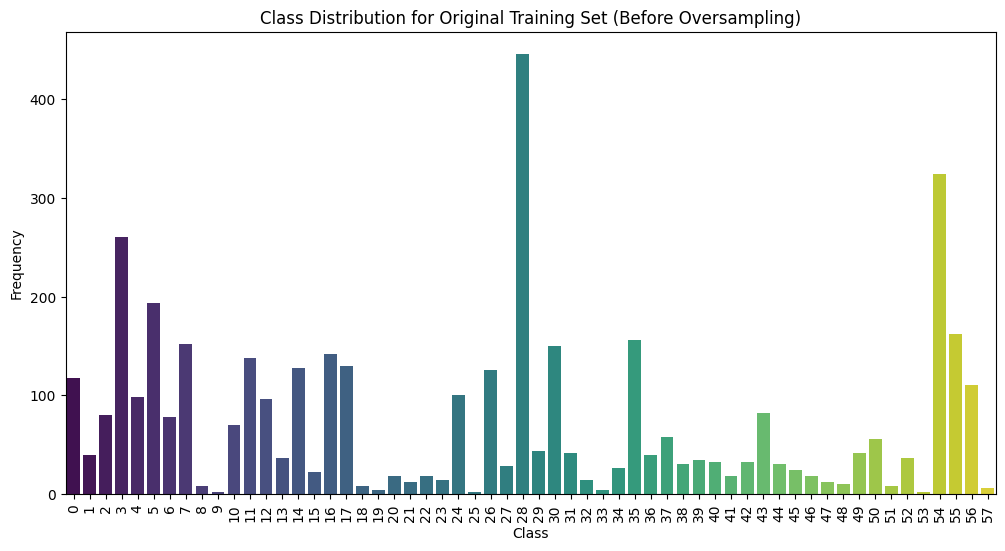

<ipython-input-5-cd802793915d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


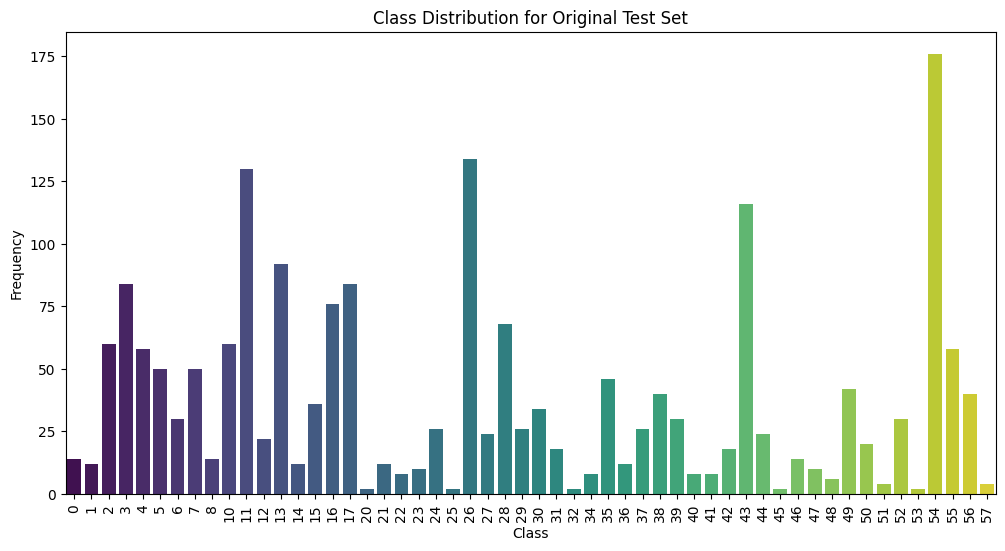

In [ ]:
# Function to plot class distribution for a given dataset
def plot_class_distribution(labels, dataset_name):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels, palette="viridis")
    plt.title(f'Class Distribution for {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Plot class distribution before oversampling
plot_class_distribution(y_train, 'Original Training Set (Before Oversampling)')
plot_class_distribution(y_test, 'Original Test Set')

We see the problem of class imbalanced existed in the original train and test datasets.

# Image Splitting, Image Preprocessing and Image Augmentation
- Combine datasets (Processing of data)
- Perform of oversampling as data augmentation techniques
- Splitting for training and testing happened (80:20 ratio)
- Splitting for training and validation happened (80:20 ratio)
- Visualization of training and testing data after oversampling

In [ ]:
# Combine the datasets
X_combined = np.concatenate([X_train, X_test], axis=0)
y_combined = np.concatenate([y_train, y_test], axis=0)

# Moderate oversampling for rare classes (keep the overall dataset size under 10,000)
def moderate_oversample(X, y, max_size=10000):
    ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)  # Oversample only minority classes
    X_resampled, y_resampled = ros.fit_resample(X.reshape(X.shape[0], -1), y)  # Reshape images to 2D for oversampling
    X_resampled = X_resampled.reshape(-1, 256, 256, 3)  # Reshape back to original shape

    # Constrain the total dataset size to be under max_size
    if len(X_resampled) > max_size:
        X_resampled = X_resampled[:max_size]
        y_resampled = y_resampled[:max_size]

    return X_resampled, y_resampled

# Apply moderate oversampling
X_oversampled, y_oversampled = moderate_oversample(X_combined, y_combined, max_size=10000)

# Stratified Split into Train and Test sets (split train into 80% and test into 20%)
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss_train_test.split(X_oversampled, y_oversampled):
    X_train_new, X_test_final = X_oversampled[train_idx], X_oversampled[test_idx]
    y_train_new, y_test_final = y_oversampled[train_idx], y_oversampled[test_idx]

# Further Stratified Split of the training set into train (80%) and validation (20%)
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss_train_val.split(X_train_new, y_train_new):
    X_train_final, X_val_new = X_train_new[train_idx], X_train_new[val_idx]
    y_train_final, y_val_new = y_train_new[train_idx], y_train_new[val_idx]

<ipython-input-7-63c9eddae5f3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


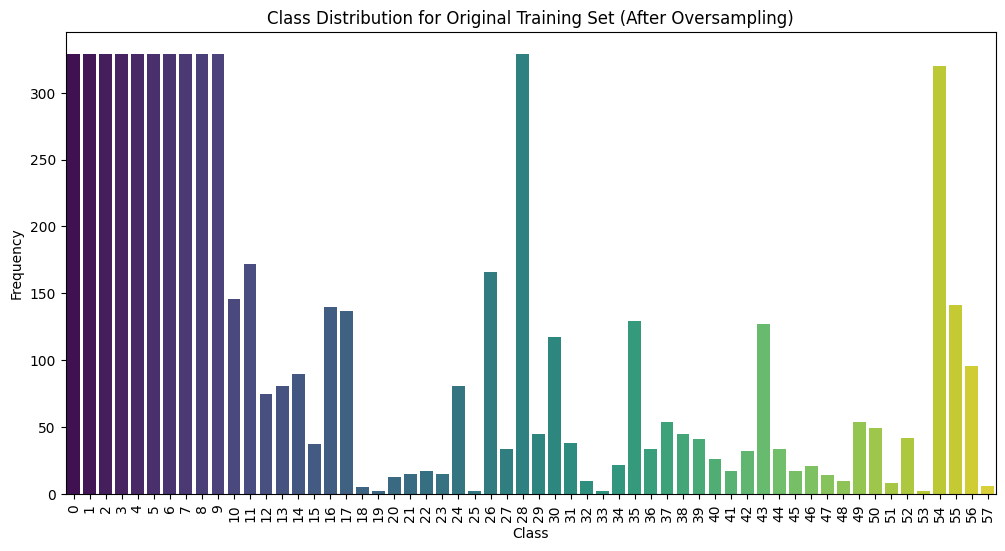

<ipython-input-7-63c9eddae5f3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


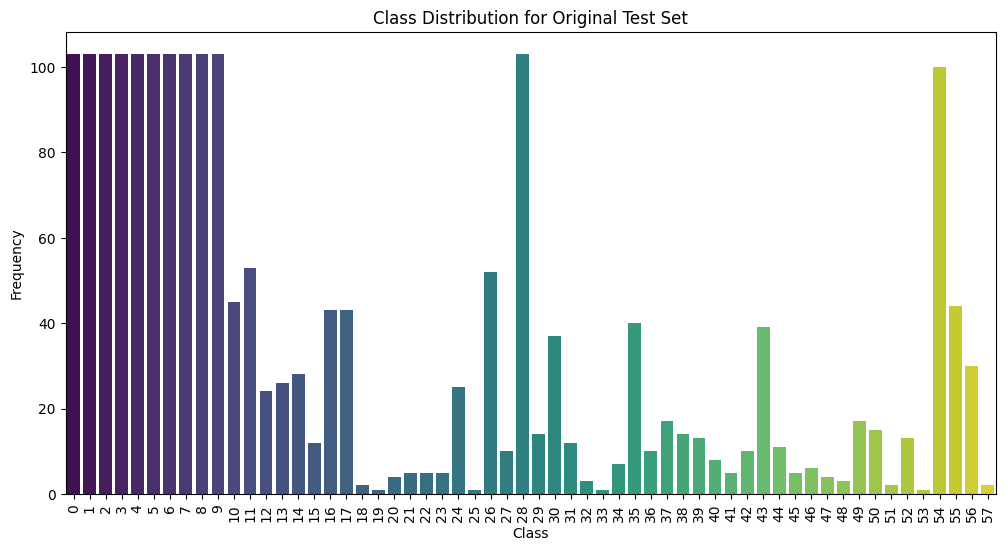

In [ ]:
# Function to plot class distribution for a given dataset
def plot_class_distribution(labels, dataset_name):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels, palette="viridis")
    plt.title(f'Class Distribution for {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Plot class distribution before oversampling
plot_class_distribution(y_train_final, 'Original Training Set (After Oversampling)')
plot_class_distribution(y_test_final, 'Original Test Set')

In [ ]:
def display_dataset_info(X, y, dataset_name):
    num_samples = X.shape[0]
    num_classes = len(np.unique(y))
    print(f"Found {num_samples} validated image filenames belonging to {num_classes} classes in {dataset_name}.")

# Display the number of samples and classes in each set
display_dataset_info(X_train_final, y_train_final, "Training Set")
display_dataset_info(X_val_new, y_val_new, "Validation Set")
display_dataset_info(X_test_final, y_test_final, "Test Set")  # Include test set display

Found 6400 validated image filenames belonging to 58 classes in Training Set.
Found 1600 validated image filenames belonging to 58 classes in Validation Set.
Found 2000 validated image filenames belonging to 58 classes in Test Set.


# Model Architecture Design
- Loading Pretrained Model of EfficientNetB0, MobileNetV3Small, Xception
- Freezing layers
- Utilizing GlobalMaxPooking2D
- Addition of Dense Layers


In [ ]:
# Model architecture with Global Max Pooling instead of Flatten
def create_ensemble_model(input_shape, num_classes, dropout_rate=0.3, l2_reg=0.01):
    efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    mobilenet_base = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
    xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in efficientnet_base.layers + mobilenet_base.layers + xception_base.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    # Global Max Pooling to reduce model size
    combined_output = Concatenate()([
        GlobalMaxPooling2D()(efficientnet_base(inputs)),
        GlobalMaxPooling2D()(mobilenet_base(inputs)),
        GlobalMaxPooling2D()(xception_base(inputs))
    ])

    x = Dense(512, kernel_regularizer=l2(l2_reg))(combined_output)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(512, kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameter Tuning with Grid Search
- Define Different Parameters for learning rate, batch size and optimizers
- Limits down the training rounds (epochs) to 3 rounds as it takes too much resources and times to compute

In [ ]:
# Define hyperparameter grid for Grid Search
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': [Adam, RMSprop, SGD],
}

best_accuracy = 0
best_params = None
best_model = None

# Grid search without data augmentation
for params in ParameterGrid(param_grid):
    print(f"Testing Parameters: {params}")

    # Create a new model for each combination of hyperparameters
    model = create_ensemble_model((256, 256, 3), len(np.unique(y_train_final)))

    # Set the optimizer with the current learning rate
    optimizer = params['optimizer'](learning_rate=params['learning_rate'])

    # Compile the model with the specified optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    # Train the model directly on the raw data (no data augmentation)
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_new, y_val_new),
        epochs=3,
        batch_size=params['batch_size'],
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_new, y_val_new)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Keep track of the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        best_model = model

# Best hyperparameters found from the grid search
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Testing Parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>}
16705208/16705208 [==============================] - 0s 0us/step


83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/3
200/200 [==============================] - 272s 1s/step - loss: 7.9254 - accuracy: 0.6522 - val_loss: 6.4949 - val_accuracy: 0.3806 - lr: 0.0010
Epoch 2/3
200/200 [==============================] - 256s 1s/step - loss: 3.0473 - accuracy: 0.7828 - val_loss: 6.2506 - val_accuracy: 0.2756 - lr: 0.0010
Epoch 3/3
50/50 [==============================] - 48s 964ms/step - loss: 7.8877 - accuracy: 0.1431
Validation Accuracy: 0.1431
Testing Parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}


Epoch 1/3
200/200 [==============================] - 260s 1s/step - loss: 7.3496 - accuracy: 0.6506 - val_loss: 9.2655 - val_accuracy: 0.1369 - lr: 0.0010
Epoch 2/3
200/200 [==============================] - 234s 1s/step - loss: 2.9317 - accuracy: 0.7694 - val_loss: 7.2063 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 3/3
50/50 [==============================] - 47s 932ms/step - loss: 5.2096 - accuracy: 0.4025
Validation Accuracy: 0.4025
Testing Parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.sgd.SGD'>}


Epoch 1/3
200/200 [==============================] - 255s 1s/step - loss: 18.1072 - accuracy: 0.1067 - val_loss: 17.0990 - val_accuracy: 0.3613 - lr: 0.0010
Epoch 2/3
200/200 [==============================] - 237s 1s/step - loss: 16.9152 - accuracy: 0.3228 - val_loss: 16.2965 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 3/3
50/50 [==============================] - 48s 955ms/step - loss: 15.7318 - accuracy: 0.6150
Validation Accuracy: 0.6150
Testing Parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>}


Epoch 1/3
200/200 [==============================] - 256s 1s/step - loss: 14.9362 - accuracy: 0.4944 - val_loss: 12.8012 - val_accuracy: 0.7350 - lr: 1.0000e-04
Epoch 2/3
200/200 [==============================] - 233s 1s/step - loss: 11.4646 - accuracy: 0.8122 - val_loss: 10.6727 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 3/3
50/50 [==============================] - 48s 957ms/step - loss: 8.9616 - accuracy: 0.8456
Validation Accuracy: 0.8456
Testing Parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}


Epoch 1/3
200/200 [==============================] - 251s 1s/step - loss: 14.7537 - accuracy: 0.5305 - val_loss: 12.8060 - val_accuracy: 0.6744 - lr: 1.0000e-04
Epoch 2/3
200/200 [==============================] - 234s 1s/step - loss: 11.1226 - accuracy: 0.8120 - val_loss: 10.2796 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 3/3
50/50 [==============================] - 48s 958ms/step - loss: 8.1994 - accuracy: 0.8331
Validation Accuracy: 0.8331
Testing Parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': <class 'keras.src.optimizers.sgd.SGD'>}


Epoch 1/3
200/200 [==============================] - 248s 1s/step - loss: 18.7754 - accuracy: 0.0170 - val_loss: 18.2871 - val_accuracy: 0.0137 - lr: 1.0000e-04
Epoch 2/3
200/200 [==============================] - 235s 1s/step - loss: 18.5551 - accuracy: 0.0256 - val_loss: 18.0789 - val_accuracy: 0.0913 - lr: 1.0000e-04
Epoch 3/3
50/50 [==============================] - 48s 955ms/step - loss: 17.8867 - accuracy: 0.1231
Validation Accuracy: 0.1231
Testing Parameters: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>}


Epoch 1/3
100/100 [==============================] - 317s 3s/step - loss: 9.3070 - accuracy: 0.6708 - val_loss: 6.5460 - val_accuracy: 0.4119 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - 305s 3s/step - loss: 3.3828 - accuracy: 0.8398 - val_loss: 5.7371 - val_accuracy: 0.2794 - lr: 0.0010
Epoch 3/3
50/50 [==============================] - 55s 1s/step - loss: 6.6722 - accuracy: 0.2387
Validation Accuracy: 0.2387
Testing Parameters: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}


Epoch 1/3
100/100 [==============================] - 321s 3s/step - loss: 8.5893 - accuracy: 0.6683 - val_loss: 8.6403 - val_accuracy: 0.2319 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - 307s 3s/step - loss: 3.3355 - accuracy: 0.8156 - val_loss: 4.3900 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 3/3
50/50 [==============================] - 53s 995ms/step - loss: 11.4105 - accuracy: 0.1125
Validation Accuracy: 0.1125
Testing Parameters: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.sgd.SGD'>}


Epoch 1/3
100/100 [==============================] - 325s 3s/step - loss: 18.4137 - accuracy: 0.0720 - val_loss: 17.9785 - val_accuracy: 0.1175 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - 311s 3s/step - loss: 17.6583 - accuracy: 0.1859 - val_loss: 17.1361 - val_accuracy: 0.3262 - lr: 0.0010
Epoch 3/3
50/50 [==============================] - 54s 1s/step - loss: 16.6308 - accuracy: 0.4544
Validation Accuracy: 0.4544
Testing Parameters: {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>}


Epoch 1/3
100/100 [==============================] - 309s 3s/step - loss: 15.6812 - accuracy: 0.4425 - val_loss: 14.1070 - val_accuracy: 0.5894 - lr: 1.0000e-04
Epoch 2/3
100/100 [==============================] - 303s 3s/step - loss: 12.6677 - accuracy: 0.7589 - val_loss: 11.9212 - val_accuracy: 0.8019 - lr: 1.0000e-04
Epoch 3/3
50/50 [==============================] - 60s 1s/step - loss: 10.4663 - accuracy: 0.8469
Validation Accuracy: 0.8469
Testing Parameters: {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}


Epoch 1/3
100/100 [==============================] - 317s 3s/step - loss: 15.5435 - accuracy: 0.4711 - val_loss: 14.0551 - val_accuracy: 0.6025 - lr: 1.0000e-04
Epoch 2/3
100/100 [==============================] - 315s 3s/step - loss: 12.4386 - accuracy: 0.7808 - val_loss: 11.6862 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 3/3
50/50 [==============================] - 53s 994ms/step - loss: 9.8539 - accuracy: 0.8562
Validation Accuracy: 0.8562
Testing Parameters: {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': <class 'keras.src.optimizers.sgd.SGD'>}


Epoch 1/3
100/100 [==============================] - 312s 3s/step - loss: 18.9406 - accuracy: 0.0117 - val_loss: 18.7072 - val_accuracy: 0.0088 - lr: 1.0000e-04
Epoch 2/3
100/100 [==============================] - 298s 3s/step - loss: 18.8433 - accuracy: 0.0131 - val_loss: 18.3729 - val_accuracy: 0.0081 - lr: 1.0000e-04
Epoch 3/3
50/50 [==============================] - 52s 978ms/step - loss: 18.2458 - accuracy: 0.0125
Validation Accuracy: 0.0125
Best Hyperparameters: {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}
Best Validation Accuracy: 0.8562


# Model Training
- Train the best model with the best parameters found from grid search
- Utilization of Early Stopping and Learning Rate Monitors
- Visualization of model structure using .summary() and plot_model function

In [ ]:
!pip install pydot
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 614.4 kB/s eta 0:00:00


In [ ]:
# Best hyperparameters found manually from the grid search
best_params = {
    'batch_size': 64,
    'learning_rate': 0.0001,
    'optimizer': RMSprop  # Using RMSprop as found during grid search
}

# Final training with the best hyperparameters
best_model = create_ensemble_model((256, 256, 3), len(np.unique(y_train_final)))

# Compile the model with the best hyperparameters
final_optimizer = best_params['optimizer'](learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the final model with the best hyperparameters
history_final = best_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_new, y_val_new),
    epochs=10,  # You can change the number of epochs based on your needs
    batch_size=best_params['batch_size'],  # Manually set the best batch size
    callbacks=[early_stopping, reduce_lr],
)

best_model.summary()

# Save the best model plot
def plot_and_save_model(model, file_name='model_plot.png'):
    # Plot and save model architecture
    plot_model(model, to_file=file_name, show_shapes=True, show_layer_names=True)
    print(f"Model architecture saved to {file_name}")

# Call the function to plot and save the architecture of the best model
plot_and_save_model(best_model, file_name='best_ensemble_model_plot.png')

# Evaluate the final model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val_new, y_val_new)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")


16705208/16705208 [==============================] - 0s 0us/step


83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 311s 3s/step - loss: 15.4599 - accuracy: 0.4866 - val_loss: 13.9066 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 2/10
100/100 [==============================] - 295s 3s/step - loss: 12.4140 - accuracy: 0.7786 - val_loss: 11.6937 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 3/10
100/100 [==============================] - 300s 3s/step - loss: 10.4445 - accuracy: 0.8856 - val_loss: 9.8146 - val_accuracy: 0.8806 - lr: 1.0000e-04
Epoch 4/10
100/100 [==============================] - 300s 3s/step - loss: 8.7916 - accuracy: 0.9370 - val_loss: 8.3723 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 5/10
100/100 [==============================] - 301s 3s/step - loss: 7.3634 - accuracy: 0.9628 - val_loss: 6.9590 - val_accuracy: 0.9262 - lr: 1.0000e-04
Epoch 6/10
100/100 [==============================] - 301s 3s/step - loss: 6.1160 - accuracy: 0.9766 - val_loss: 5.7503 - val_accu

# Evaluation and Performance Metrics
- Accuracy, Precision, F1 Score, Recall, Confusion Matrix, Validation accuracy, Test accuracy, Learning Curve (Mentioned)
- Visualize all performance metrics that is in the state of training, testing and validation

200/200 [==============================] - 186s 929ms/step - loss: 2.6468 - accuracy: 0.9641
Final Training Accuracy: 0.9641
50/50 [==============================] - 46s 922ms/step - loss: 2.7318 - accuracy: 0.9463
Final Validation Accuracy: 0.9463
63/63 [==============================] - 61s 967ms/step - loss: 2.7448 - accuracy: 0.9460
Final Test Accuracy: 0.9460
63/63 [==============================] - 64s 966ms/step
Training Accuracy: 0.9641
Training Precision: 0.9682
Training Recall: 0.9641
Training F1 Score: 0.9591
Validation Accuracy: 0.9463
Validation Precision: 0.9466
Validation Recall: 0.9463
Validation F1 Score: 0.9388
Test Accuracy: 0.9460
Test Precision: 0.9508
Test Recall: 0.9460
Test F1 Score: 0.9393


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


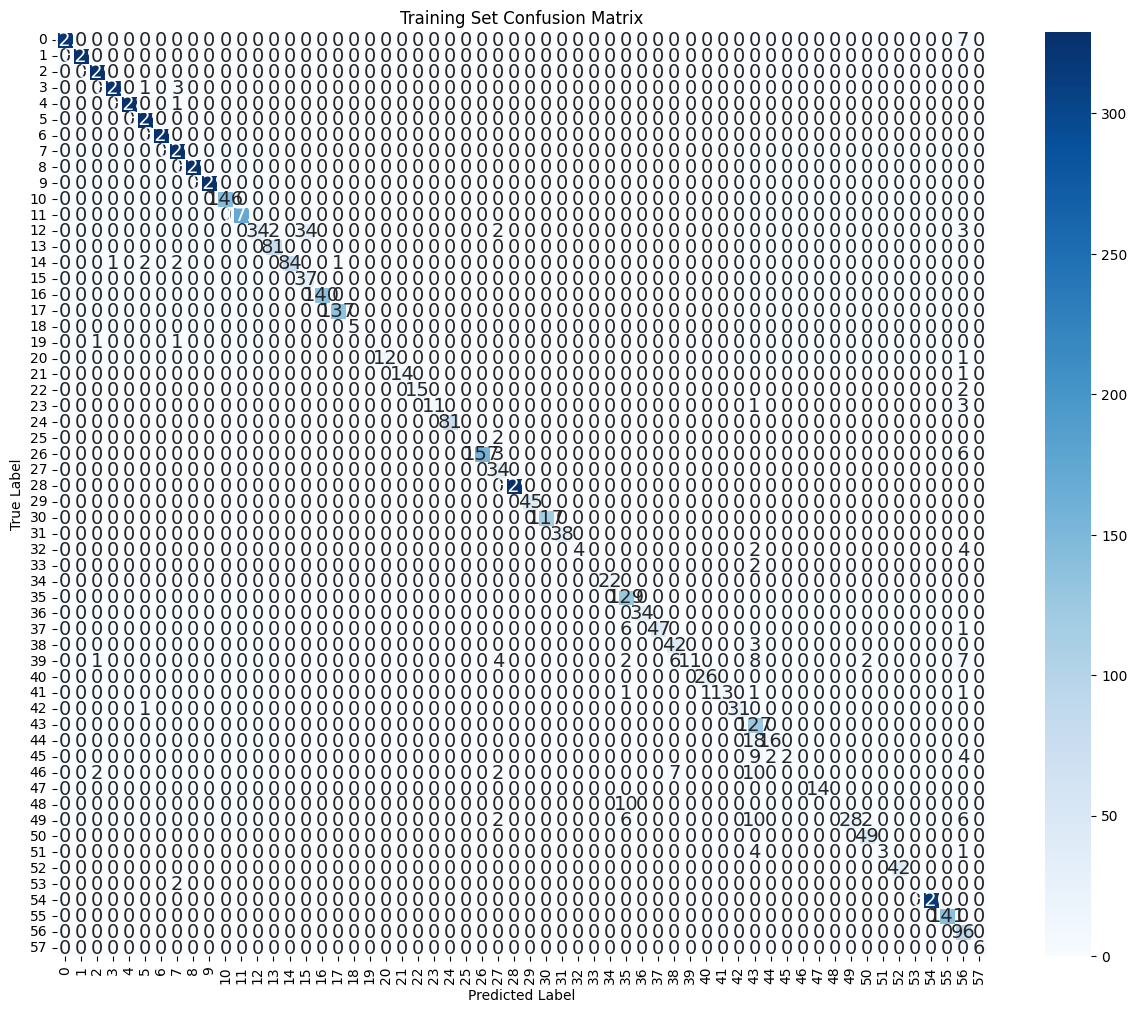

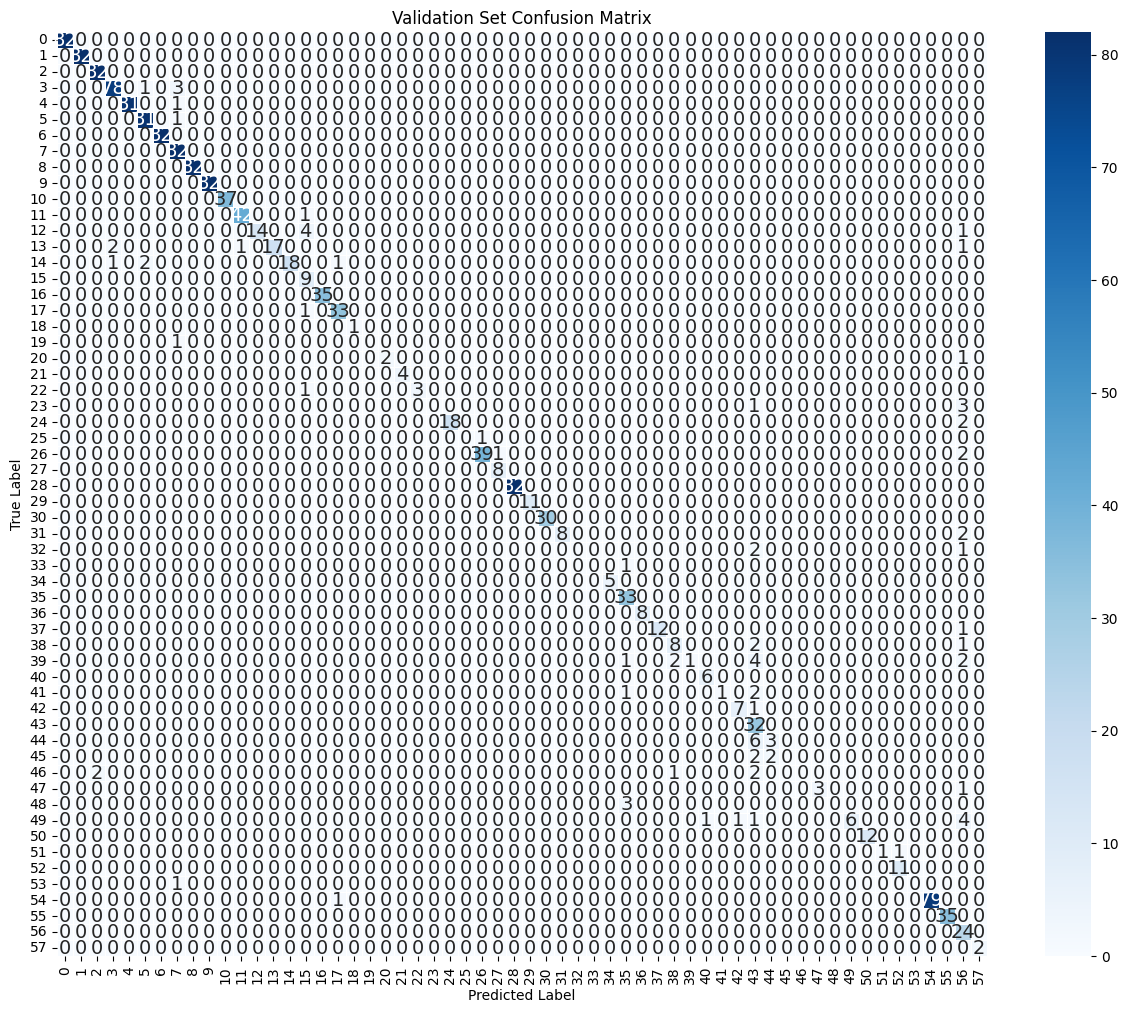

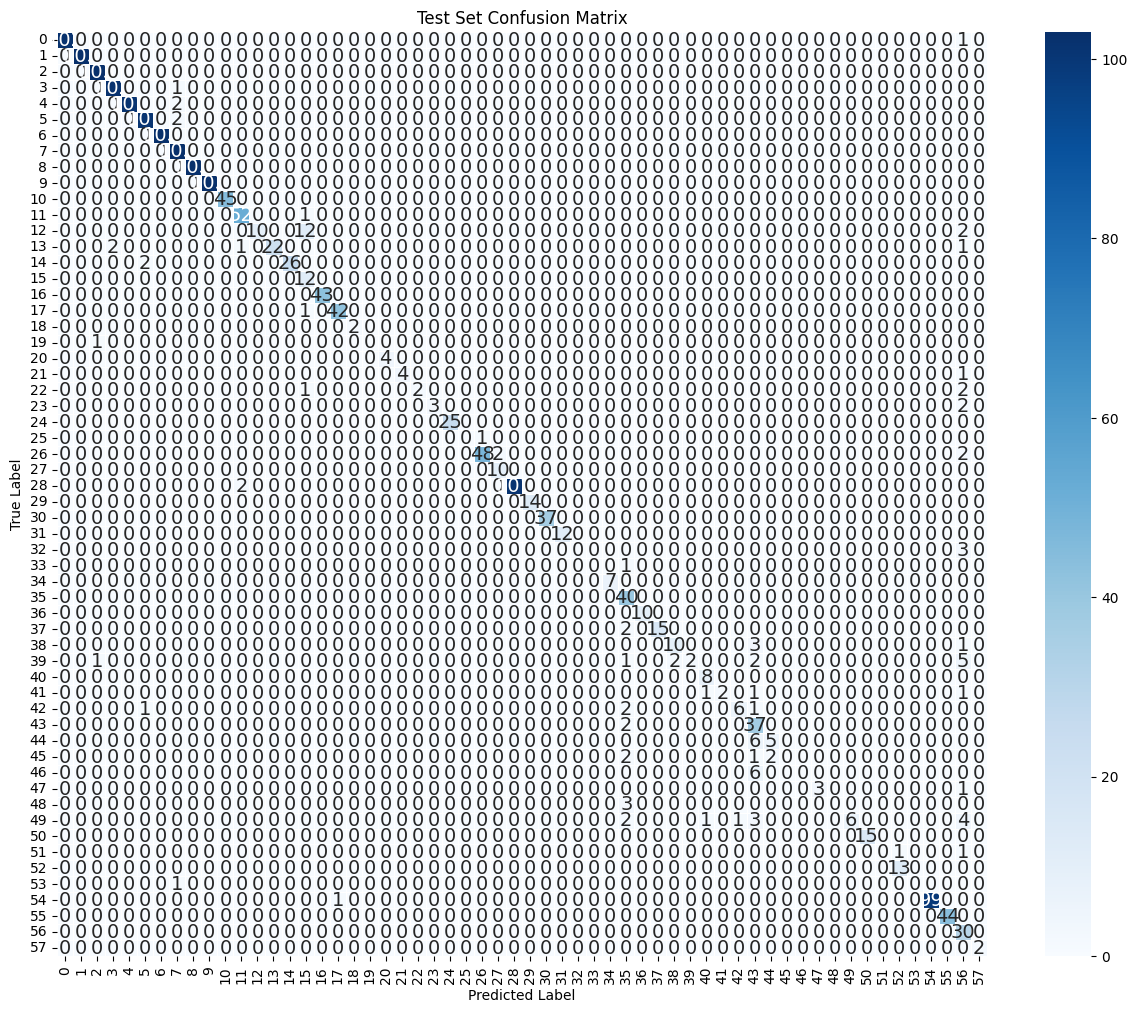

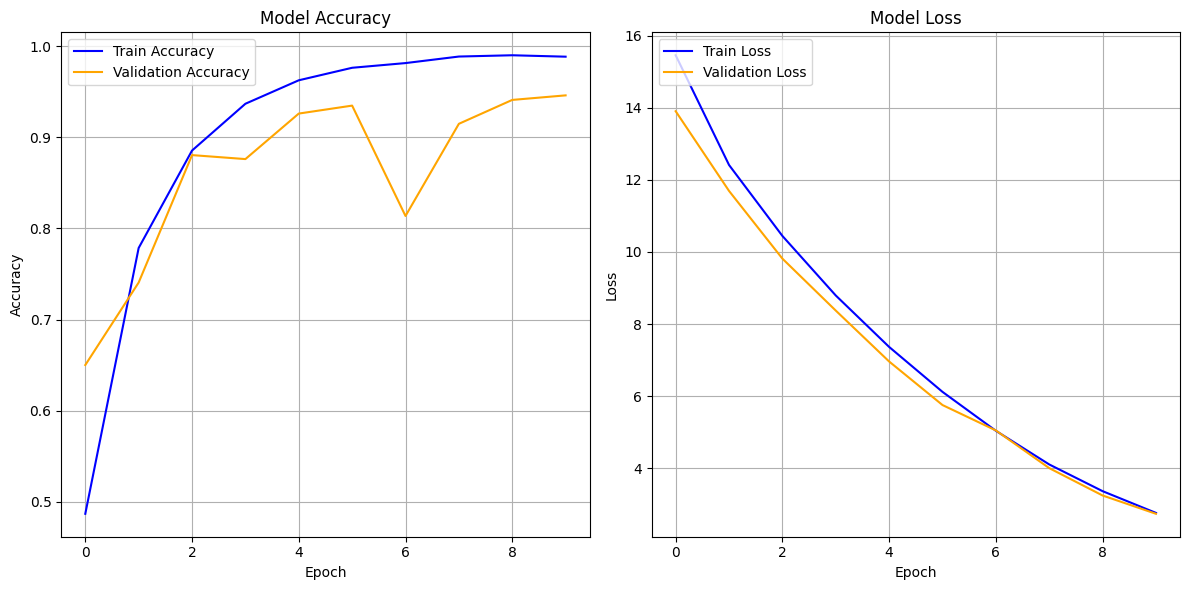

In [ ]:
# --------------------- Final Model Evaluation ---------------------

# Evaluate the best model on the training set
train_loss, train_accuracy = best_model.evaluate(X_train_final, y_train_final)
print(f"Final Training Accuracy: {train_accuracy:.4f}")

# Generate predictions for the training set
y_pred_train = np.argmax(best_model.predict(X_train_final), axis=-1)

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val_new, y_val_new)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions for the validation set
y_pred_val = np.argmax(best_model.predict(X_val_new), axis=-1)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_final, y_test_final)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
y_pred_test = np.argmax(best_model.predict(X_test_final), axis=-1)

# --------------------- Performance Metrics for Training, Validation, and Test Sets ---------------------
# Training set metrics
train_acc = accuracy_score(y_train_final, y_pred_train)
train_precision = precision_score(y_train_final, y_pred_train, average='weighted')
train_recall = recall_score(y_train_final, y_pred_train, average='weighted')
train_f1 = f1_score(y_train_final, y_pred_train, average='weighted')

# Validation set metrics
val_acc = accuracy_score(y_val_new, y_pred_val)
val_precision = precision_score(y_val_new, y_pred_val, average='weighted')
val_recall = recall_score(y_val_new, y_pred_val, average='weighted')
val_f1 = f1_score(y_val_new, y_pred_val, average='weighted')

# Test set metrics
test_acc = accuracy_score(y_test_final, y_pred_test)
test_precision = precision_score(y_test_final, y_pred_test, average='weighted')
test_recall = recall_score(y_test_final, y_pred_test, average='weighted')
test_f1 = f1_score(y_test_final, y_pred_test, average='weighted')

# Print the results for each set
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# --------------------- Confusion Matrices ---------------------
# Confusion matrix for the training set
# Confusion matrix for the training set
cm_train = confusion_matrix(y_train_final, y_pred_train)
plt.figure(figsize=(15, 12))  # Increase the figure size to give more space
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_train_final),
            yticklabels=np.unique(y_train_final),
            annot_kws={"size": 14},  # Increase annotation font size
            linewidths=.5)  # Add slight separation between cells
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.show()

# Confusion matrix for the validation set
cm_val = confusion_matrix(y_val_new, y_pred_val)
plt.figure(figsize=(15, 12))  # Increase the figure size to give more space
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_val_new),
            yticklabels=np.unique(y_val_new),
            annot_kws={"size": 14},  # Increase annotation font size
            linewidths=.5)  # Add slight separation between cells
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.show()

# Confusion matrix for the test set
cm_test = confusion_matrix(y_test_final, y_pred_test)
plt.figure(figsize=(15, 12))  # Increase the figure size to give more space
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_final),
            yticklabels=np.unique(y_test_final),
            annot_kws={"size": 14},  # Increase annotation font size
            linewidths=.5)  # Add slight separation between cells
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.show()

# Function to plot accuracy and loss over epochs
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot learning curves
plot_learning_curves(history_final)

In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to a ConcreteFunction
model = best_model
full_model = tf.function(lambda x: model(x))
concrete_function = full_model.get_concrete_function(tf.TensorSpec([1, 256, 256, 3], model.inputs[0].dtype))

# Convert ConcreteFunction to a frozen graph
frozen_func = convert_variables_to_constants_v2(concrete_function)
frozen_graph = frozen_func.graph

# Calculate FLOPs
run_meta = tf.compat.v1.RunMetadata()
opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

# Use TensorFlow's profiler to calculate FLOPs
flops = tf.compat.v1.profiler.profile(graph=frozen_graph, run_meta=run_meta, options=opts)

# Convert to GFLOPs
gflops = flops.total_float_ops / 10**9
print(f"GFLOPs: {gflops:.2f}")

GFLOPs: 13.09


# Best Model Saving for deployment
- Saving model in google drive
- Used .keras format as the latest format (tensorflow version 2.15.0)

In [ ]:
# Save the best model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
model_path = '/content/drive/My Drive/final_ensemble_model_ver4.keras'
best_model.save(model_path)
print(f"Model saved to {model_path}")

Mounted at /content/drive
Model saved to /content/drive/My Drive/final_ensemble_model_ver4.keras


# Prediction Lists (Classified and Misclassified)
- Plot 20 each for classified and misclassified images from model prediction

63/63 [==============================] - 60s 948ms/step
Number of correctly classified images: 1892
Number of misclassified images: 108


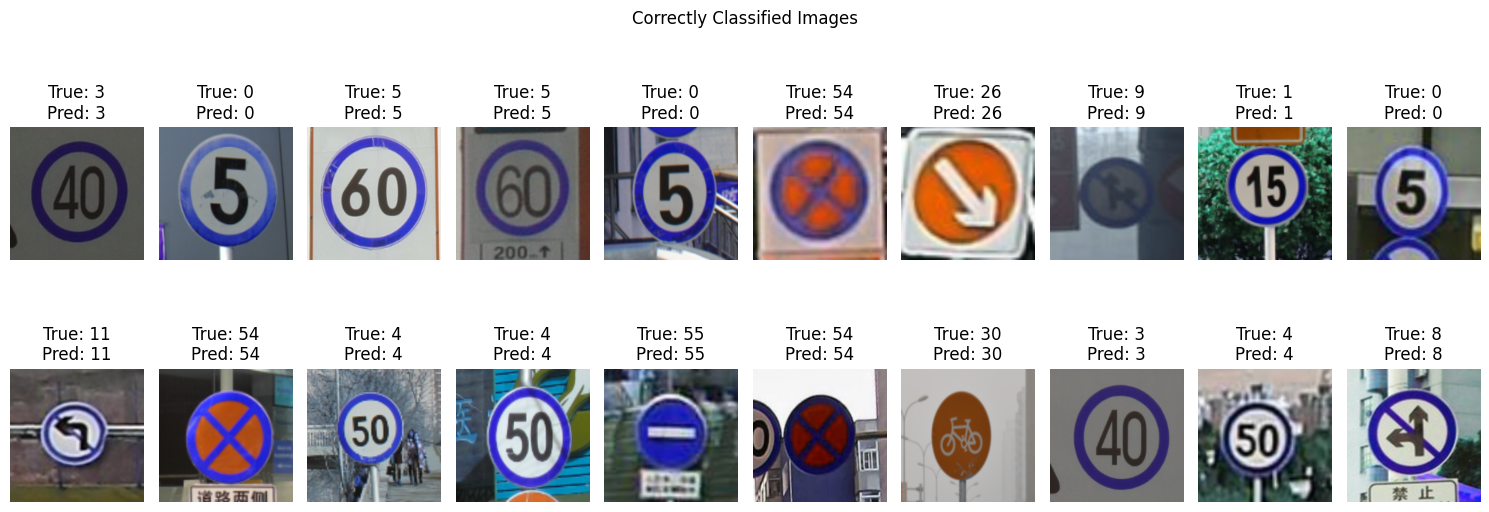

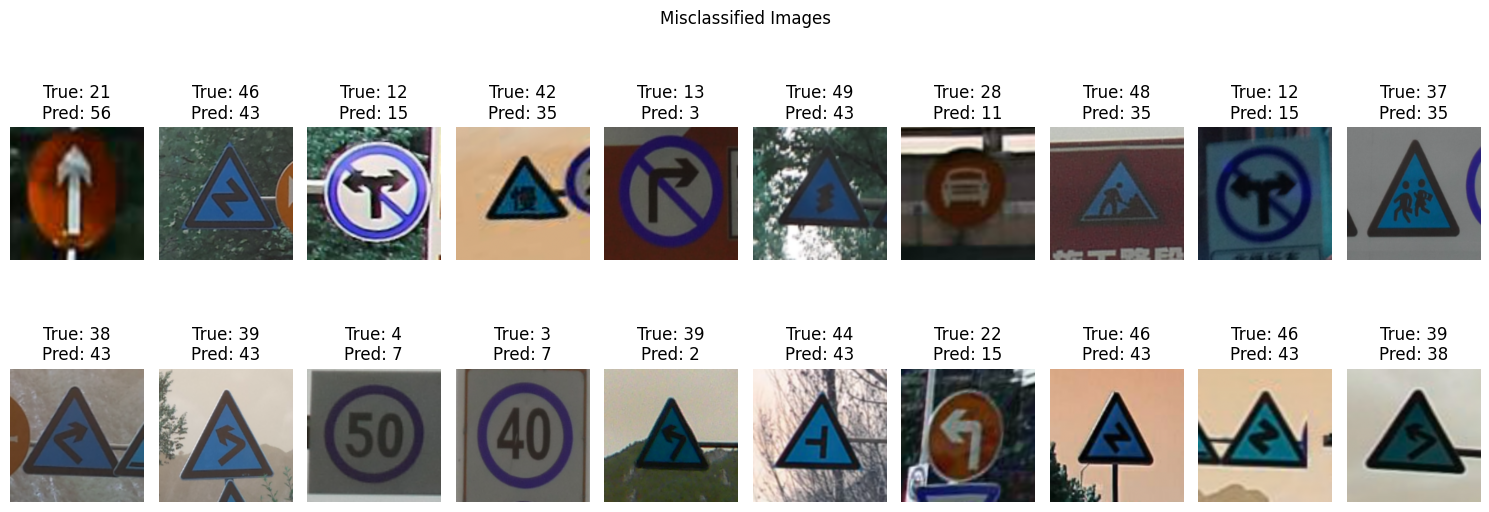

In [ ]:
# Function to plot images (classified or misclassified)
def plot_images(X, y_true, y_pred, indices, title, num_images=10):
    """
    X: Images dataset (e.g., X_test_final)
    y_true: Ground truth labels (e.g., y_test_final)
    y_pred: Predicted labels (e.g., y_pred_test)
    indices: Indices of images to plot (either classified or misclassified)
    title: Title for the plot
    num_images: Number of images to display
    """
    # Limit the number of images to display
    num_images = min(num_images, len(indices))

    # Create subplots
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(num_images):
        idx = indices[i]
        axes[i].imshow(X[idx].squeeze())  # Assuming images are (256, 256, 3)
        axes[i].axis('off')

        # Add title with true and predicted labels
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Function to list and plot classified/misclassified images
def list_and_plot_classified_misclassified(X, y_true, y_pred, num_images=10):
    """
    X: Images dataset (e.g., X_test_final)
    y_true: Ground truth labels (e.g., y_test_final)
    y_pred: Predicted labels (e.g., y_pred_test)
    num_images: Number of images to display
    """
    # Get indices of classified and misclassified images
    classified_indices = np.where(y_true == y_pred)[0]
    misclassified_indices = np.where(y_true != y_pred)[0]

    print(f"Number of correctly classified images: {len(classified_indices)}")
    print(f"Number of misclassified images: {len(misclassified_indices)}")

    # Plot classified images
    plot_images(X, y_true, y_pred, classified_indices, title='Correctly Classified Images', num_images=num_images)

    # Plot misclassified images
    plot_images(X, y_true, y_pred, misclassified_indices, title='Misclassified Images', num_images=num_images)

# Generate predictions for the test set
y_pred_test = np.argmax(best_model.predict(X_test_final), axis=-1)

# List and plot classified and misclassified images
list_and_plot_classified_misclassified(X_test_final, y_test_final, y_pred_test, num_images=20)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Modified function to plot side-by-side images for classified or misclassified images
def plot_images_side_by_side(X, y_true, y_pred, indices, title, num_images=10):
    """
    X: Images dataset (e.g., X_test_final)
    y_true: Ground truth labels (e.g., y_test_final)
    y_pred: Predicted labels (e.g., y_pred_test)
    indices: Indices of images to plot (either classified or misclassified)
    title: Title for the plot
    num_images: Number of images to display
    """
    # Limit the number of images to display
    num_images = min(num_images, len(indices))

    # Create subplots (2 columns: one for original, one for predictions)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

    for i in range(num_images):
        idx = indices[i]

        # Original image on the left
        axes[i, 0].imshow(X[idx].squeeze(), cmap='gray')  # Assuming grayscale images, adjust as needed
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"True: {y_true[idx]}")

        # Predicted image (same as original) on the right
        axes[i, 1].imshow(X[idx].squeeze(), cmap='gray')  # Adjust cmap if color images
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Pred: {y_pred[idx]}")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Function to list and plot classified/misclassified images side by side
def list_and_plot_classified_misclassified_side_by_side(X, y_true, y_pred, num_images=10):
    """
    X: Images dataset (e.g., X_test_final)
    y_true: Ground truth labels (e.g., y_test_final)
    y_pred: Predicted labels (e.g., y_pred_test)
    num_images: Number of images to display
    """
    # Get indices of classified and misclassified images
    classified_indices = np.where(y_true == y_pred)[0]
    misclassified_indices = np.where(y_true != y_pred)[0]

    print(f"Number of correctly classified images: {len(classified_indices)}")
    print(f"Number of misclassified images: {len(misclassified_indices)}")

    # Plot classified images
    plot_images_side_by_side(X, y_true, y_pred, classified_indices, title='Correctly Classified Images', num_images=num_images)

    # Plot misclassified images
    plot_images_side_by_side(X, y_true, y_pred, misclassified_indices, title='Misclassified Images', num_images=num_images)

# Generate predictions for the test set
y_pred_test = np.argmax(best_model.predict(X_test_final), axis=-1)

# List and plot classified and misclassified images
list_and_plot_classified_misclassified_side_by_side(X_test_final, y_test_final, y_pred_test, num_images=10)